# DECaLS and WISE (+ SDSS) Quality Data Cuts

To download the data, firstly the [north DECaLS data (DR8)](https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/north/external/survey-dr8-north-specObj-dr14.fits) need to be merged with the [south DECaLS data (DR8)](https://portal.nersc.gov/project/cosmo/data/legacysurvey/dr8/south/external/survey-dr8-south-specObj-dr14.fits). Then, they need to be stacked with the [SDSS DR14 table](https://data.sdss.org/sas/dr14/sdss/spectro/redux/specObj-dr14.fits). 

The script to do this can be found here: [script to produce merged data file](https://github.com/astrovarv/DECALS_data_cleaning/blob/main/scripts/load_train_data.py).

For the purposes of this demostartion we simply load the already prepared data.

In [2]:
import pandas as pd

from plots_scripts import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'monospace'
                            })
import warnings
warnings.simplefilter(action='ignore')

In [4]:
# load the data
data = pd.read_csv('all_objects.csv')

In this data, two correction have already been made:

1.   The north-to-south shift has been performed.
2.   the objetcs with negative or zero fluxes were removed.

This was done because it is simpler to carry them out directly after merging the data sets. 

The script for these can be found here: [north-south shift](https://github.com/astrovarv/DECALS_data_cleaning/blob/main/scripts/north_shift.py).


In [5]:
# number of quasars, stars and agalxies in the data
df = data
grouped = df.groupby(df['CLASS'])
df.groupby(df['CLASS']).size()

CLASS
b'GALAXY'    2316101
b'QSO   '     605781
b'STAR  '     681763
dtype: int64

###Galactic Extinction Correction

In [6]:
# separate stars from quasars
qsos = df[(df['CLASS'] == 'b\'QSO   \'')]
qsos['CLASS'] = 'QSO'
stars = df[(df['CLASS'] == 'b\'STAR  \'')]
stars['CLASS'] = 'STAR'

In [7]:
# apply galactic extinction separately

for j in [qsos]:
  fluxes = ['G', 'R', 'Z', 'W1', 'W2']
  for i in fluxes:
    # original unextincted fluxes for the classifier:
    j['FLUX_{}_ORIG'.format(i)] = j['FLUX_{}'.format(i)]
    j['FLUX_IVAR_{}_ORIG'.format(i)] = j['FLUX_IVAR_{}'.format(i)]
    # extincted fluxes for the model:
    vals = flux_to_mag(j['FLUX_{}'.format(i)], j['MW_TRANSMISSION_{}'.format(i)], 1, 1)
    vals2 = flux_to_mag(j['FLUX_{}'.format(i)], j['MW_TRANSMISSION_{}'.format(i)], 1, 0)
    vals3 = (j['MW_TRANSMISSION_{}'.format(i)]**2)*j['FLUX_IVAR_{}'.format(i)]
    j['AB_FLUX_{}'.format(i)] = vals
    j['FLUX_{}'.format(i)] = vals2
    j['FLUX_IVAR_{}'.format(i)] = vals3

for j in [stars]:
  fluxes = ['G', 'R', 'Z', 'W1', 'W2']
  for i in fluxes:
    # unextincted fluxes for the model:
    vals = flux_to_mag(j['FLUX_{}'.format(i)], j['MW_TRANSMISSION_{}'.format(i)], 0, 1)
    j['AB_FLUX_{}'.format(i)] = vals
    # extincted fluxes for the classifier:
    j['FLUX_{}_EXT'.format(i)] = flux_to_mag(j['FLUX_{}'.format(i)], j['MW_TRANSMISSION_{}'.format(i)], 1, 0)
    j['FLUX_IVAR_{}_EXT'.format(i)] = (j['MW_TRANSMISSION_{}'.format(i)]**2)*j['FLUX_IVAR_{}'.format(i)]

# merge back together and remove 
df = pd.concat([stars, qsos], axis = 0)

In [8]:
grouped = df.groupby(df['CLASS'])
df.groupby(df['CLASS']).size()

CLASS
QSO     605781
STAR    681763
dtype: int64

Plot the colour-colour ditributions of quasars and stars.

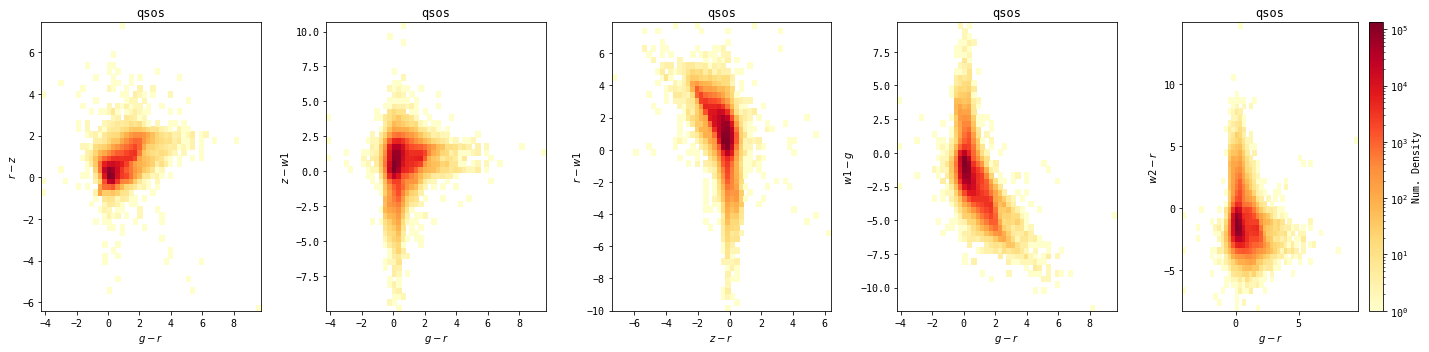

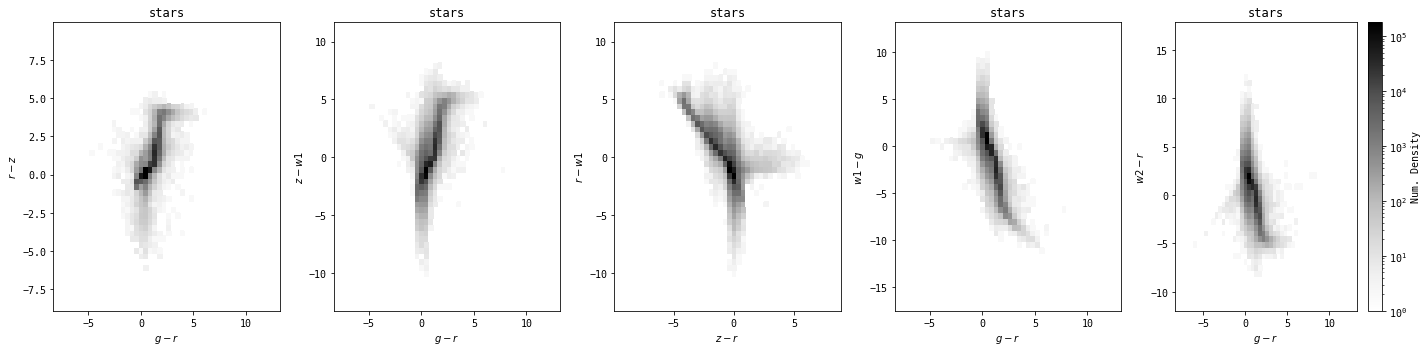

In [9]:
hist2d(df, 'qsos')
hist2d(df, 'stars')

### Only keep PSF objects

In [14]:
# only consider PSF objects (not extended objects)
df = df[df['TYPE'] == 'PSF ']

### Remove objects with poor estimates of redshift

In [17]:
# remove z warning
df = df[(df['ZWARNING'] == 0) | (df['ZWARNING'] == 16)]

### Only keep z < 4 objects

In [16]:
# remove high redshift objects
df = df[df['Z'] < 4]

Can now see a big effect on the spread in the colours of quasars:

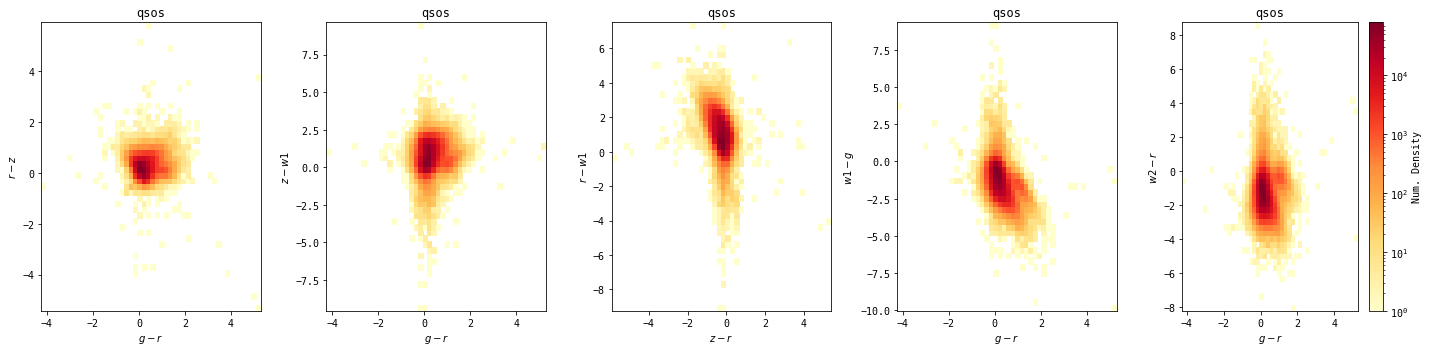

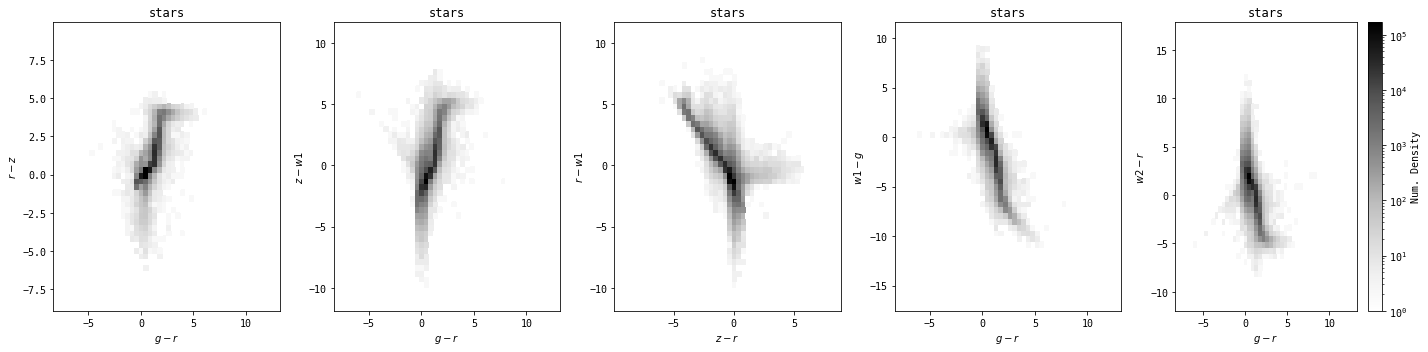

In [18]:
hist2d(df, 'qsos')
hist2d(df, 'stars')

### Only keep 18 < r < 22 objects

In [20]:
# r band magnitude cut
df = df[(df['AB_FLUX_R'] > 18) & (df['AB_FLUX_R'] < 22)]

This has a large effect on stars, making the main-sequence more pronounced:

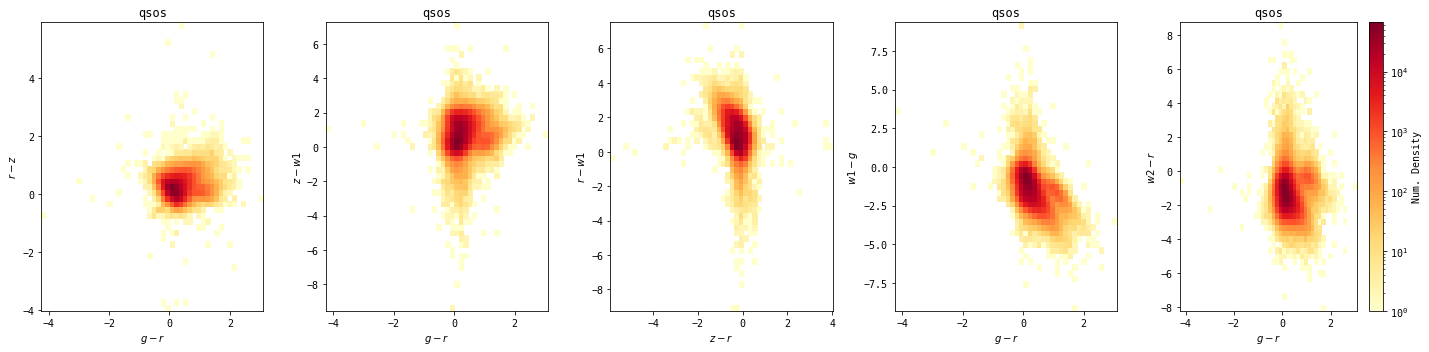

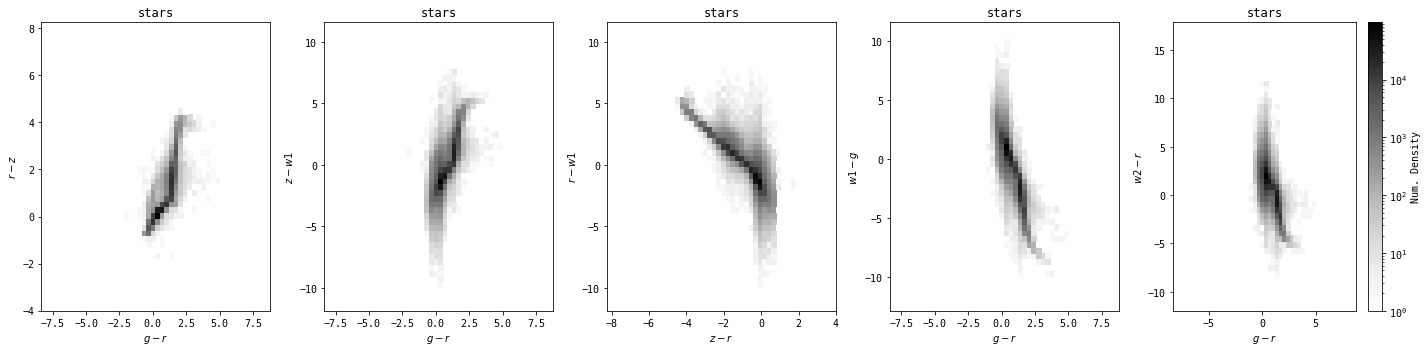

In [21]:
hist2d(df, 'qsos')
hist2d(df, 'stars')

### Only keep object with over 3 images

In [22]:
# cut observation number to 3 and above
bands = ['G', 'Z', 'R', 'W1', 'W2']
for i in bands:
    df = df[df['NOBS_'+i] > 0]

### Remove objects with masked pixels

In [23]:
df = df[df['MASKBITS'] == 0]
df = df[(df['ALLMASK_G'] == 0) & (df['ALLMASK_R'] == 0) & (df['ALLMASK_Z'] == 0)]
df = df[(df['WISEMASK_W1'] == 0) & (df['WISEMASK_W2'] == 0)]

## Final Data

In [24]:
grouped = df.groupby(df['CLASS'])
df.groupby(df['CLASS']).size()

CLASS
QSO     451177
STAR    311991
dtype: int64

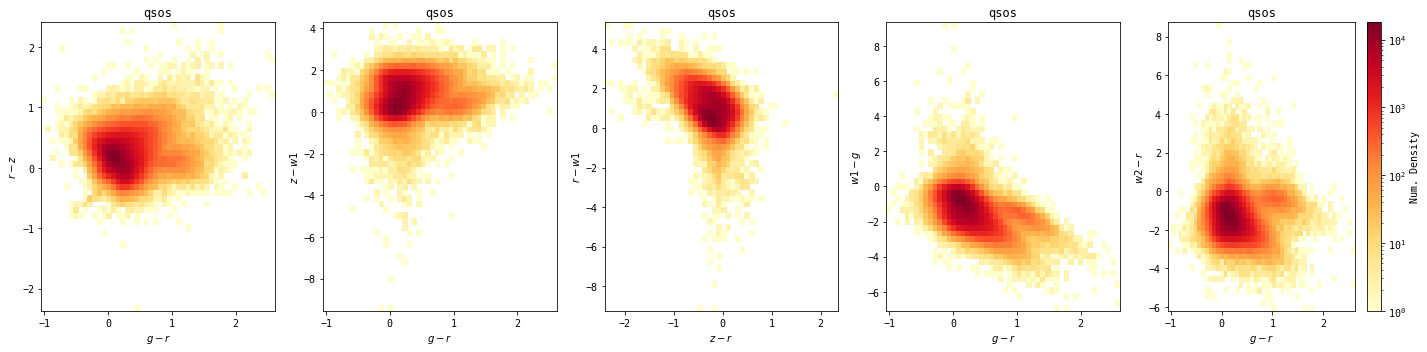

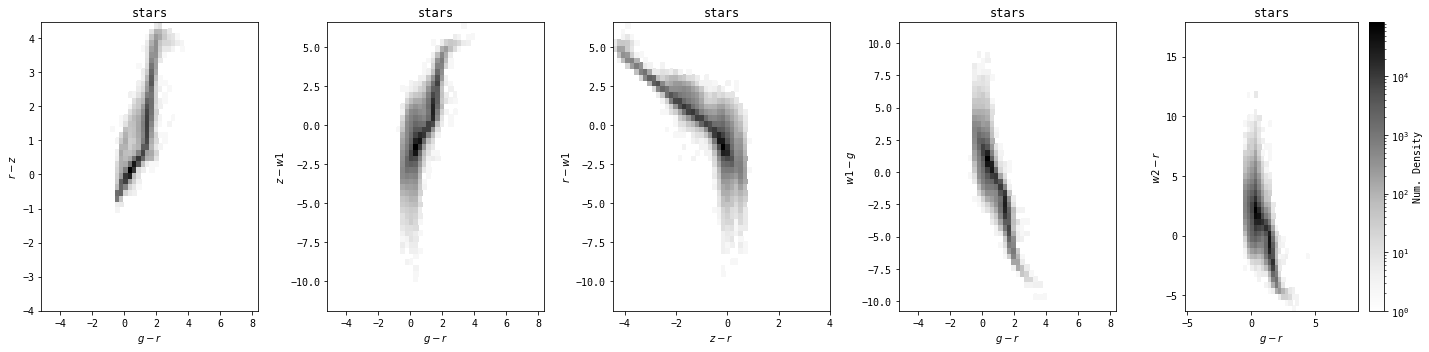

In [25]:
hist2d(df, 'qsos')
hist2d(df, 'stars')